# Aplicación del modelo de aprendizaje automático no supervisado K-Means (1-D) para efectos de identificar los clusters y el umbral máximo a partir del cual un operador de telecomunicaciones se considera pequeño para efectos de determinar su elegibilidad en el Comité de Pequeños Operadores.

### Datos

El umbral máximo para determinar si un proveedor de servicios de telecomunicaciones, con fines comerciales, es elegible para participar en el Comité, será calculado a partir de los datos de ingreso nominal acumulados anualmente (al cuarto trimestre del año anterior), los cuales han sido reportados por los operadores y publicados en el Banco de Información de Telecomunicaciones del Instituto Federal de Telecomunicaciones.

Como primer paso, serán acumulados los ingresos anuales publicados en el Banco de Información de Telecomunicaciones, con información al cierre del cuarto trimestre del año inmediato anterior y se realizan algunos ajustes tendientes a consolidar los datos por grupo de interés económico, a fin de comenzar el análisis correspondiente.


### Metodología

El referido umbral se calcula a partir del método de agrupamiento conocido como k-medias o k-means (como se le denomina en el idioma inglés). Se trata de un algoritmo de aprendizaje automático no supervisado que busca identificar los grupos de observaciones (i.e. los ingresos nominales acumulados anualmente) que son similares. Para ello, se parte del concepto básico de “distancia” para determinar similitudes entre los operadores de telecomunicaciones. Por ejemplo, si tomamos los ingresos nominales acumulados anuales de dos empresas, la distancia entre sus respectivos datos es una medida del grado de cercanía o similitud que existe entre las mismas.

Como se ilustra en el siguiente diagrama, se define aleatoriamente un prototipo para cada grupo y se mide la distancia que tienen los ingresos nominales acumulados anualmente de cada elemento respecto al prototipo o centroide (v.gr. punto medio de los objetos). Posteriormente, ese centroide se vuelve a definir para cada grupo y este proceso se repite hasta que los objetos no cambien de grupo y que los centroides no sufran variaciones; lo que confirma que existe evidencia de que los grupos están correctamente definidos.

Para la determinación del número óptimo de clusters o grupos (k), se utiliza el criterio denominado Elbow, que consiste en seleccionar el k donde la reducción de la suma de la distancia cuadrática de los elementos de cada grupo a su centroide (inercia) ya no es significativa. Lo que implica que un cluster adicional ya no aumenta significativamente la similitud entre los elementos de cada grupo, reduciendo la eficiencia en la agrupación sin una ganancia significativa en la convergencia o similitud de cada elemento en cada grupo . En este sentido, el principio de selección óptima de k es el de tener un valor reducido de inercia y el número menor de centroides o agrupaciones.

<img title="a title" alt="Alt text" src="kmeans.png">


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
from scipy.cluster.vq import vq, kmeans, whiten
import dataframe_image as dfi
import math
import seaborn as sns
from sklearn.cluster import KMeans


In [2]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

In [3]:
# Es importante mencionar que esta base de datos proviene de la última actualización en el Banco de Información de Telecomunicaciones
# del IFT, consultado el 19 de agosto de 2022. 
# Por este motivo se incluye en este repositorio esa versión de la base de datos a efectos de que si desea replicar el 
# resultado, lo haga con este conjunto de datos, toda vez que la información en el BIT podría variar sin previo aviso.

ingresos = pd.read_csv('TD_INGRESOS_TELECOM_ITE_VA.csv', encoding ='Latin1')
ingresos

,FOLIO,ANIO,TRIM,FECHA,CONCESIONARIO,K_EMPRESA,EMPRESA,K_GRUPO,GRUPO,I_FIJO_MOVIL,INGRESOS_TOTAL_E,I_ANUAL_TRIM
0,100028,2021,1,15-mar-21,ADOLFO MERINO MEDINA,C0089,CABLEMAS,G004,GRUPO TELEVISA,Fijo,389669,Trimestral
1,100028,2021,2,15-jun-21,ADOLFO MERINO MEDINA,C0089,CABLEMAS,G004,GRUPO TELEVISA,Fijo,407900,Trimestral
2,100028,2021,3,15-sep-21,ADOLFO MERINO MEDINA,C0089,CABLEMAS,G004,GRUPO TELEVISA,Fijo,416000,Trimestral
3,100028,2021,4,15DEC2021,ADOLFO MERINO MEDINA,C0089,CABLEMAS,G004,GRUPO TELEVISA,Fijo,434431,Trimestral
4,100029,2021,1,15-mar-21,AGUSTIN PEREZ VIEYRA,C0009,AGUSTIN PEREZ VIEYRA,C009,AGUSTIN PEREZ VIEYRA,Fijo,797686.05,Trimestral
...,...,...,...,...,...,...,...,...,...,...,...,...
2456,999997,2014,4,15DEC2014,"MICRO SISTEMAS INTERNACIONAL, S.A. DE C.V.",C0384,MICROSISTEMAS INTERNACIONAL,C384,MICROSISTEMAS INTERNACIONAL,Fijo,NaN,Trimestral
2457,999997,2015,1,15-mar-15,"MICRO SISTEMAS INTERNACIONAL, S.A. DE C.V.",C0384,MICROSISTEMAS INTERNACIONAL,C384,MICROSISTEMAS INTERNACIONAL,Fijo,NaN,Trimestral
2458,999997,2015,2,15-jun-15,"MICRO SISTEMAS INTERNACIONAL, S.A. DE C.V.",C0384,MICROSISTEMAS INTERNACIONAL,C384,MICROSISTEMAS INTERNACIONAL,Fijo,"720,000.00",Trimestral
2459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
ingresos['GRUPO'].unique()

array(['GRUPO TELEVISA', 'AGUSTIN PEREZ VIEYRA',
       'ARELY ISABEL GONGORA PECH', 'FRANCISCO GUERRA GARCIA',
       'GABRIEL BUTRON CHIAPA', 'GUILLERMO MEDELLIN MILAN',
       'GUILLERMO ZARATE GARCIA', 'ISALIA MORENO ZETINA',
       'JAIME SANCHEZ SANCHEZ', 'JESUS MIGUEL FERNANDEZ GUERRERO',
       'JOSE JULIAN SACRAMENTO GARZA', 'MANUEL LOPEZ AVILA',
       'MARCO ANTONIO ROSALES HERRERA', 'ROBERTO LOPEZ BRAVO',
       'SARA QUIROZ CHAPA', 'IUSACELL-UNEFÓN', 'LOGITEL', 'TV-K',
       'TELEFÓNICA', 'TELECAB', 'ULTRAVISION', 'STARGROUP', 'ALESTRA',
       'AXTEL', 'MEGACABLE-MCM', 'TELESISTEMAS PENINSULARES', 'GLOBALSAT',
       'TELECOM NACIONAL', 'TOTALPLAY', 'AXESAT', 'AIRECABLE', 'CABLECOM',
       'USA TELECOM', 'CODITEL', 'COMCAB', 'SINOTECA', 'MULTICOM',
       'COORDINADORA DE TV POR CABLE', 'TV OJO CALIENTE',
       'GTAC REDES DE FIBRA OPTICA', 'TRANSTELCO', 'AMÉRICA MÓVIL',
       'TELECABLE DE TICUL', 'EUTELSAT AMERICAS', 'TV REY',
       'CABLEVISION RED', 'MARCATEL', '

In [5]:
len(ingresos['GRUPO'].unique())

158

In [6]:
ingresos.columns

Index(['FOLIO', 'ANIO', 'TRIM', 'FECHA', 'CONCESIONARIO', 'K_EMPRESA',
       'EMPRESA', 'K_GRUPO', 'GRUPO', 'I_FIJO_MOVIL', 'INGRESOS_TOTAL_E',
       'I_ANUAL_TRIM'],
      dtype='object')

In [7]:
# seleccionamos columnas relevantes
variables_relevantes = ['ANIO','TRIM', 'CONCESIONARIO', 'EMPRESA', 'GRUPO', 'INGRESOS_TOTAL_E']

ingresos2 = ingresos[variables_relevantes]
ingresos2

,ANIO,TRIM,CONCESIONARIO,EMPRESA,GRUPO,INGRESOS_TOTAL_E
0,2021,1,ADOLFO MERINO MEDINA,CABLEMAS,GRUPO TELEVISA,389669
1,2021,2,ADOLFO MERINO MEDINA,CABLEMAS,GRUPO TELEVISA,407900
2,2021,3,ADOLFO MERINO MEDINA,CABLEMAS,GRUPO TELEVISA,416000
3,2021,4,ADOLFO MERINO MEDINA,CABLEMAS,GRUPO TELEVISA,434431
4,2021,1,AGUSTIN PEREZ VIEYRA,AGUSTIN PEREZ VIEYRA,AGUSTIN PEREZ VIEYRA,797686.05
...,...,...,...,...,...,...
2456,2014,4,"MICRO SISTEMAS INTERNACIONAL, S.A. DE C.V.",MICROSISTEMAS INTERNACIONAL,MICROSISTEMAS INTERNACIONAL,NaN
2457,2015,1,"MICRO SISTEMAS INTERNACIONAL, S.A. DE C.V.",MICROSISTEMAS INTERNACIONAL,MICROSISTEMAS INTERNACIONAL,NaN
2458,2015,2,"MICRO SISTEMAS INTERNACIONAL, S.A. DE C.V.",MICROSISTEMAS INTERNACIONAL,MICROSISTEMAS INTERNACIONAL,"720,000.00"
2459,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# seleccionar sólo los registro de 2021
ingresos = ingresos2[ingresos2['ANIO']==2021]
ingresos

,ANIO,TRIM,CONCESIONARIO,EMPRESA,GRUPO,INGRESOS_TOTAL_E
0,2021,1,ADOLFO MERINO MEDINA,CABLEMAS,GRUPO TELEVISA,389669
1,2021,2,ADOLFO MERINO MEDINA,CABLEMAS,GRUPO TELEVISA,407900
2,2021,3,ADOLFO MERINO MEDINA,CABLEMAS,GRUPO TELEVISA,416000
3,2021,4,ADOLFO MERINO MEDINA,CABLEMAS,GRUPO TELEVISA,434431
4,2021,1,AGUSTIN PEREZ VIEYRA,AGUSTIN PEREZ VIEYRA,AGUSTIN PEREZ VIEYRA,797686.05
...,...,...,...,...,...,...
2444,2021,1,"BROCOMUNICACIONES MOVILES, S.A.P.I. DE C.V.",BROMOVIL,BROMOVIL,NaN
2445,2021,2,"BROCOMUNICACIONES MOVILES, S.A.P.I. DE C.V.",BROMOVIL,BROMOVIL,NaN
2446,2021,3,"BROCOMUNICACIONES MOVILES, S.A.P.I. DE C.V.",BROMOVIL,BROMOVIL,83434.44
2447,2021,4,"BROCOMUNICACIONES MOVILES, S.A.P.I. DE C.V.",BROMOVIL,BROMOVIL,237150.7


# Corrección de grupos de interés en el conjunto de datos

Con base en la información proporcionada por la Unidad de Competencia Económica respecto a los Grupos de Interés que tienen identificados, se realizaron los siguientes cambios al marco de datos de ingresos que estamos utilizando para el cálculo del umbral de pequeño operador; publicado en el BIT al 19 de agosto de 2022:

- Se incluye en el grupo de interés económico HISPASAT a la empresa AXESS NET.SOLUTIONS MEXICO, S.A. DE C.V.
- Se incluye en el grupo de interés económico GRUPO TELEVISA a la empresa GRUPO DE TELECOMUNICACIONES DE ALTA CAPACIDAD, S.A.P.I. DE C.V. (GTAC).
- Se incluye en el grupo de interés económico TRANSTELCO a la empresa MAXCOM TELECOMUNICACIONES, S.A.B. DE C.V.
- Se incluyen en el grupo de interés económico MVS las empresas: MVSTV y DSH.


In [9]:
# Primero HISPASAT
print(ingresos[ingresos['EMPRESA']=='AXESS'])
ingresos['GRUPO'] = ingresos['GRUPO'].replace(['AXESAT'],'HISPASAT')
ingresos[ingresos['EMPRESA']=='AXESS']

     ANIO  TRIM                             CONCESIONARIO EMPRESA   GRUPO  \
345  2021     2  AXESS NET.SOLUTIONS MEXICO, S.A. DE C.V.   AXESS  AXESAT   
346  2021     3  AXESS NET.SOLUTIONS MEXICO, S.A. DE C.V.   AXESS  AXESAT   
347  2021     4  AXESS NET.SOLUTIONS MEXICO, S.A. DE C.V.   AXESS  AXESAT   

    INGRESOS_TOTAL_E  
345         60667313  
346         68625291  
347         88628131  


<ipython-input-9-7dc6878566fb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ingresos['GRUPO'] = ingresos['GRUPO'].replace(['AXESAT'],'HISPASAT')


,ANIO,TRIM,CONCESIONARIO,EMPRESA,GRUPO,INGRESOS_TOTAL_E
345,2021,2,"AXESS NET.SOLUTIONS MEXICO, S.A. DE C.V.",AXESS,HISPASAT,60667313
346,2021,3,"AXESS NET.SOLUTIONS MEXICO, S.A. DE C.V.",AXESS,HISPASAT,68625291
347,2021,4,"AXESS NET.SOLUTIONS MEXICO, S.A. DE C.V.",AXESS,HISPASAT,88628131


In [10]:
# Segundo Grupo Televisa
print(ingresos[ingresos['CONCESIONARIO']=='GRUPO DE TELECOMUNICACIONES DE ALTA CAPACIDAD, S.A.P.I. DE C.V.'])
ingresos['GRUPO'] = ingresos['GRUPO'].replace(['GTAC REDES DE FIBRA OPTICA'],'GRUPO TELEVISA')
ingresos[ingresos['EMPRESA']=='GTAC REDES DE FIBRA OPTICA']

     ANIO  TRIM                                      CONCESIONARIO  \
525  2021     1  GRUPO DE TELECOMUNICACIONES DE ALTA CAPACIDAD,...   
526  2021     2  GRUPO DE TELECOMUNICACIONES DE ALTA CAPACIDAD,...   
527  2021     3  GRUPO DE TELECOMUNICACIONES DE ALTA CAPACIDAD,...   
528  2021     4  GRUPO DE TELECOMUNICACIONES DE ALTA CAPACIDAD,...   

                        EMPRESA                       GRUPO INGRESOS_TOTAL_E  
525  GTAC REDES DE FIBRA OPTICA  GTAC REDES DE FIBRA OPTICA        228948471  
526  GTAC REDES DE FIBRA OPTICA  GTAC REDES DE FIBRA OPTICA        196098888  
527  GTAC REDES DE FIBRA OPTICA  GTAC REDES DE FIBRA OPTICA        355289838  
528  GTAC REDES DE FIBRA OPTICA  GTAC REDES DE FIBRA OPTICA        282197600  


<ipython-input-10-98df99182ec1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ingresos['GRUPO'] = ingresos['GRUPO'].replace(['GTAC REDES DE FIBRA OPTICA'],'GRUPO TELEVISA')


,ANIO,TRIM,CONCESIONARIO,EMPRESA,GRUPO,INGRESOS_TOTAL_E
525,2021,1,"GRUPO DE TELECOMUNICACIONES DE ALTA CAPACIDAD,...",GTAC REDES DE FIBRA OPTICA,GRUPO TELEVISA,228948471
526,2021,2,"GRUPO DE TELECOMUNICACIONES DE ALTA CAPACIDAD,...",GTAC REDES DE FIBRA OPTICA,GRUPO TELEVISA,196098888
527,2021,3,"GRUPO DE TELECOMUNICACIONES DE ALTA CAPACIDAD,...",GTAC REDES DE FIBRA OPTICA,GRUPO TELEVISA,355289838
528,2021,4,"GRUPO DE TELECOMUNICACIONES DE ALTA CAPACIDAD,...",GTAC REDES DE FIBRA OPTICA,GRUPO TELEVISA,282197600


In [11]:
# Tercero Transtelco
print(ingresos[ingresos['CONCESIONARIO']=='MAXCOM TELECOMUNICACIONES, S.A.B. DE C.V.'])
ingresos['GRUPO'] = ingresos['GRUPO'].replace(['MAXCOM'],'TRANSTELCO')
ingresos[ingresos['EMPRESA']=='MAXCOM']

      ANIO  TRIM                              CONCESIONARIO EMPRESA   GRUPO  \
1820  2021     1  MAXCOM TELECOMUNICACIONES, S.A.B. DE C.V.  MAXCOM  MAXCOM   
1821  2021     2  MAXCOM TELECOMUNICACIONES, S.A.B. DE C.V.  MAXCOM  MAXCOM   
1822  2021     3  MAXCOM TELECOMUNICACIONES, S.A.B. DE C.V.  MAXCOM  MAXCOM   
1823  2021     4  MAXCOM TELECOMUNICACIONES, S.A.B. DE C.V.  MAXCOM  MAXCOM   

     INGRESOS_TOTAL_E  
1820        154326158  
1821        157745550  
1822        154123979  
1823        157402483  


<ipython-input-11-19fa40c9fb05>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ingresos['GRUPO'] = ingresos['GRUPO'].replace(['MAXCOM'],'TRANSTELCO')


,ANIO,TRIM,CONCESIONARIO,EMPRESA,GRUPO,INGRESOS_TOTAL_E
1820,2021,1,"MAXCOM TELECOMUNICACIONES, S.A.B. DE C.V.",MAXCOM,TRANSTELCO,154326158
1821,2021,2,"MAXCOM TELECOMUNICACIONES, S.A.B. DE C.V.",MAXCOM,TRANSTELCO,157745550
1822,2021,3,"MAXCOM TELECOMUNICACIONES, S.A.B. DE C.V.",MAXCOM,TRANSTELCO,154123979
1823,2021,4,"MAXCOM TELECOMUNICACIONES, S.A.B. DE C.V.",MAXCOM,TRANSTELCO,157402483


In [12]:
ingresos[ingresos['EMPRESA']=='DISH']

,ANIO,TRIM,CONCESIONARIO,EMPRESA,GRUPO,INGRESOS_TOTAL_E
1067,2021,1,"COMERCIALIZADORA DE FRECUENCIAS SATELITALES, S...",DISH,DISH-MVS,1373486398
1068,2021,2,"COMERCIALIZADORA DE FRECUENCIAS SATELITALES, S...",DISH,DISH-MVS,1298658657
1069,2021,3,"COMERCIALIZADORA DE FRECUENCIAS SATELITALES, S...",DISH,DISH-MVS,1264047268
1070,2021,4,"COMERCIALIZADORA DE FRECUENCIAS SATELITALES, S...",DISH,DISH-MVS,1211104115


In [13]:
# Quinto DISH-MVS
print(ingresos[ingresos['CONCESIONARIO']=='COMERCIALIZADORA DE FRECUENCIAS SATELITALES, S. DE R.L. DE C.V.'])
ingresos['GRUPO'] = ingresos['GRUPO'].replace(['DISH-MVS'],'MVS')
ingresos[ingresos['EMPRESA']=='DISH']

      ANIO  TRIM                                      CONCESIONARIO EMPRESA  \
1067  2021     1  COMERCIALIZADORA DE FRECUENCIAS SATELITALES, S...    DISH   
1068  2021     2  COMERCIALIZADORA DE FRECUENCIAS SATELITALES, S...    DISH   
1069  2021     3  COMERCIALIZADORA DE FRECUENCIAS SATELITALES, S...    DISH   
1070  2021     4  COMERCIALIZADORA DE FRECUENCIAS SATELITALES, S...    DISH   

         GRUPO INGRESOS_TOTAL_E  
1067  DISH-MVS       1373486398  
1068  DISH-MVS       1298658657  
1069  DISH-MVS       1264047268  
1070  DISH-MVS       1211104115  


<ipython-input-13-3309da2ae005>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ingresos['GRUPO'] = ingresos['GRUPO'].replace(['DISH-MVS'],'MVS')


,ANIO,TRIM,CONCESIONARIO,EMPRESA,GRUPO,INGRESOS_TOTAL_E
1067,2021,1,"COMERCIALIZADORA DE FRECUENCIAS SATELITALES, S...",DISH,MVS,1373486398
1068,2021,2,"COMERCIALIZADORA DE FRECUENCIAS SATELITALES, S...",DISH,MVS,1298658657
1069,2021,3,"COMERCIALIZADORA DE FRECUENCIAS SATELITALES, S...",DISH,MVS,1264047268
1070,2021,4,"COMERCIALIZADORA DE FRECUENCIAS SATELITALES, S...",DISH,MVS,1211104115


In [14]:
# Sexto DISH-MVS
print(ingresos[ingresos['EMPRESA']=='MVSTV'])
ingresos['GRUPO'] = ingresos['GRUPO'].replace(['MVSTV'],'MVS')
ingresos[ingresos['EMPRESA']=='MVSTV']

      ANIO  TRIM          CONCESIONARIO EMPRESA  GRUPO INGRESOS_TOTAL_E
1704  2021     1  COMBAND, S.A. DE C.V.   MVSTV  MVSTV       1854470.77
1705  2021     2  COMBAND, S.A. DE C.V.   MVSTV  MVSTV       1355173.22
1706  2021     3  COMBAND, S.A. DE C.V.   MVSTV  MVSTV       2842490.96
1707  2021     4  COMBAND, S.A. DE C.V.   MVSTV  MVSTV       5357193.15


<ipython-input-14-b827a2e0f14c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ingresos['GRUPO'] = ingresos['GRUPO'].replace(['MVSTV'],'MVS')


,ANIO,TRIM,CONCESIONARIO,EMPRESA,GRUPO,INGRESOS_TOTAL_E
1704,2021,1,"COMBAND, S.A. DE C.V.",MVSTV,MVS,1854470.77
1705,2021,2,"COMBAND, S.A. DE C.V.",MVSTV,MVS,1355173.22
1706,2021,3,"COMBAND, S.A. DE C.V.",MVSTV,MVS,2842490.96
1707,2021,4,"COMBAND, S.A. DE C.V.",MVSTV,MVS,5357193.15


In [15]:
# Existen huecos en los datos públicos en proveedores importantes como Axtel (4T2021), Cablevisión, Virgin Mobile (4T2021), QBO CEL (2T Y 4T2021), por mencionar algunos.
ingresos[ingresos['INGRESOS_TOTAL_E'].isna()==True]
# no obstante, partimos de que es la información disponible para este ejercicio.

,ANIO,TRIM,CONCESIONARIO,EMPRESA,GRUPO,INGRESOS_TOTAL_E
267,2021,4,"AXTEL, S.A.B. DE C.V.",AXTEL,AXTEL,NaN
514,2021,2,"CABLEMAS TELECOMUNICACIONES, S.A. DE C.V.",IZZI,GRUPO TELEVISA,NaN
766,2021,2,"CABLEVISION RED, S.A. DE C.V.",CABLEVISION RED,GRUPO TELEVISA,NaN
838,2021,2,"TV CABLE DE ORIENTE, S.A. DE C.V.",IZZI,GRUPO TELEVISA,NaN
940,2021,2,"TELEVISION INTERNACIONAL, S.A. DE C.V.",TELEVISION INTERNACIONAL,GRUPO TELEVISA,NaN
1434,2021,2,"CABLEVISION, S.A. DE C.V.",CABLEVISION,GRUPO TELEVISA,NaN
1929,2021,4,"VIRGIN MOBILE MEXICO, S. DE R.L. DE C.V.",VIRGIN MOBILE,VIRGIN MOBILE,NaN
2010,2021,2,"KUBO CEL, S.A.P.I. DE C.V.",QBO CEL,QBO CEL,NaN
2012,2021,4,"KUBO CEL, S.A.P.I. DE C.V.",QBO CEL,QBO CEL,NaN
2151,2021,1,"COMNET, S.A. DE C.V.",COMNET,COMNET,NaN


In [16]:
ingresos.dtypes

ANIO                float64
TRIM                float64
CONCESIONARIO        object
EMPRESA              object
GRUPO                object
INGRESOS_TOTAL_E     object
dtype: object

In [17]:
# no consideremos los missing values

ingresos = ingresos[ingresos['INGRESOS_TOTAL_E'].isna()!=True]
ingresos

,ANIO,TRIM,CONCESIONARIO,EMPRESA,GRUPO,INGRESOS_TOTAL_E
0,2021,1,ADOLFO MERINO MEDINA,CABLEMAS,GRUPO TELEVISA,389669
1,2021,2,ADOLFO MERINO MEDINA,CABLEMAS,GRUPO TELEVISA,407900
2,2021,3,ADOLFO MERINO MEDINA,CABLEMAS,GRUPO TELEVISA,416000
3,2021,4,ADOLFO MERINO MEDINA,CABLEMAS,GRUPO TELEVISA,434431
4,2021,1,AGUSTIN PEREZ VIEYRA,AGUSTIN PEREZ VIEYRA,AGUSTIN PEREZ VIEYRA,797686.05
...,...,...,...,...,...,...
2442,2021,3,"MARKETING 358, S.A. DE C.V.",MARKETING 358,MARKETING 358,398927.16
2443,2021,4,"MARKETING 358, S.A. DE C.V.",MARKETING 358,MARKETING 358,1924097.07
2446,2021,3,"BROCOMUNICACIONES MOVILES, S.A.P.I. DE C.V.",BROMOVIL,BROMOVIL,83434.44
2447,2021,4,"BROCOMUNICACIONES MOVILES, S.A.P.I. DE C.V.",BROMOVIL,BROMOVIL,237150.7


In [18]:
lista_columnas = ['GRUPO', 'INGRESOS_TOTAL_E']
ingresos2 = ingresos[lista_columnas]
ingresos2

,GRUPO,INGRESOS_TOTAL_E
0,GRUPO TELEVISA,389669
1,GRUPO TELEVISA,407900
2,GRUPO TELEVISA,416000
3,GRUPO TELEVISA,434431
4,AGUSTIN PEREZ VIEYRA,797686.05
...,...,...
2442,MARKETING 358,398927.16
2443,MARKETING 358,1924097.07
2446,BROMOVIL,83434.44
2447,BROMOVIL,237150.7


In [19]:
ingresos2['INGRESOS_TOTAL_E'] = pd.to_numeric(ingresos2['INGRESOS_TOTAL_E'])

<ipython-input-19-0e8230c4d54c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ingresos2['INGRESOS_TOTAL_E'] = pd.to_numeric(ingresos2['INGRESOS_TOTAL_E'])


In [20]:
# ya no tenemos missings

ingresos2

,GRUPO,INGRESOS_TOTAL_E
0,GRUPO TELEVISA,389669
1,GRUPO TELEVISA,407900
2,GRUPO TELEVISA,416000
3,GRUPO TELEVISA,434431
4,AGUSTIN PEREZ VIEYRA,797686
...,...,...
2442,MARKETING 358,398927
2443,MARKETING 358,1924097
2446,BROMOVIL,83434
2447,BROMOVIL,237151


In [21]:
# Agrupados
ingresos_agrupados = ingresos2.groupby(['GRUPO']).sum()
ingresos_agrupados

,INGRESOS_TOTAL_E
GRUPO,
ADDINTELI,5534961
AGUSTIN PEREZ VIEYRA,2726562
AIRECABLE,13327321
ALTAN,2834607753
AMÉRICA MÓVIL,338320139531
...,...
VERIZON SERVICIOS EMPRESARIALES MEXICO,258650617
VIRGIN MOBILE,146563495
WEEX,33446465


In [22]:
ingresos_agrupados = ingresos_agrupados.reset_index().sort_values(by=['INGRESOS_TOTAL_E'], ascending=False)
ingresos_agrupados

,GRUPO,INGRESOS_TOTAL_E
4,AMÉRICA MÓVIL,338320139531
36,GRUPO TELEVISA,59301496226
6,AT&T,55793781168
98,TELEFÓNICA,24871583943
60,MEGACABLE-MCM,24676771857
...,...,...
35,GRUPO CORPORATIVO ZUNUN PAZ,340986
100,TELMOVIL,332069
9,BROMOVIL,320585
23,EDUARDO PEDRERO PEREZ,68200


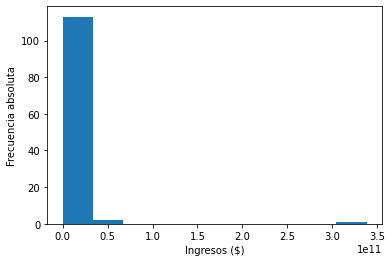

NormaltestResult(statistic=238.15581101258346, pvalue=1.928069666088079e-52)


In [23]:
plt.hist(ingresos_agrupados['INGRESOS_TOTAL_E'])
plt.xlabel('Ingresos ($)')
plt.ylabel('Frecuencia absoluta')
plt.show()
print(sts.normaltest(ingresos_agrupados['INGRESOS_TOTAL_E'])) # no pasa la prueba de normalidad (sesgo)

In [24]:
# cuántos ceros tenemos en las cifras
m = ingresos_agrupados[ingresos_agrupados['INGRESOS_TOTAL_E']!=0]

ingresos_agrupados_transformables = m

ingresos_agrupados_transformables

,GRUPO,INGRESOS_TOTAL_E
4,AMÉRICA MÓVIL,338320139531
36,GRUPO TELEVISA,59301496226
6,AT&T,55793781168
98,TELEFÓNICA,24871583943
60,MEGACABLE-MCM,24676771857
...,...,...
35,GRUPO CORPORATIVO ZUNUN PAZ,340986
100,TELMOVIL,332069
9,BROMOVIL,320585
23,EDUARDO PEDRERO PEREZ,68200


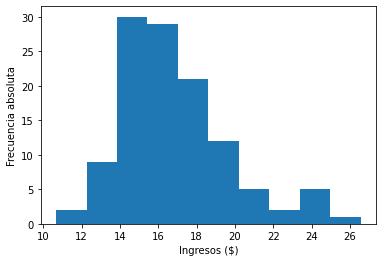

NormaltestResult(statistic=19.12498898738056, pvalue=7.03171739590705e-05)


In [25]:
# Aplicar logarítmos para reducir el efecto de la magnitud de los datos.
ln_ingresos = np.log(ingresos_agrupados_transformables['INGRESOS_TOTAL_E']) 

plt.hist(ln_ingresos)
plt.xlabel('Ingresos ($)')
plt.ylabel('Frecuencia absoluta')
plt.show()
print(sts.normaltest(ln_ingresos))

In [26]:
# Análisis de varianza
var_numpy = np.var(ln_ingresos, ddof = 0)
print(f"La varianza del ln de los ingresos totales en 2021 es de {var_numpy}")
print(f'Lo que implica $ {np.exp(var_numpy)}')

sd_numpy = np.std(ln_ingresos,ddof = 0)
print(f"La desviación estándar del ln de los ingresos totales en 2021 es de {sd_numpy}")
print(f'Lo que implica $ {np.exp(sd_numpy)}')

La varianza del ln de los ingresos totales en 2021 es de 8.286548415208602
Lo que implica $ 3970.1073563151735
La desviación estándar del ln de los ingresos totales en 2021 es de 2.878636554900358
Lo que implica $ 17.79000094683033


In [27]:
var_numpy2 = np.var(ingresos_agrupados['INGRESOS_TOTAL_E'], ddof = 0)
print(f"La varianza del ln de los ingresos totales en 2021 es de {var_numpy2}")

sd_numpy2 = np.std(ingresos_agrupados['INGRESOS_TOTAL_E'],ddof = 0)
print(f"La desviación estándar de los ingresos totales en 2021 es de {sd_numpy2}")


La varianza del ln de los ingresos totales en 2021 es de 1.0373849757817884e+21
La desviación estándar de los ingresos totales en 2021 es de 32208461245.17265


In [28]:
# La media
media = np.mean(ln_ingresos)
print(f"La media del ln de los ingresos 2021 es de {media}")
print(f'Lo que implica una media de $ {np.exp(media)}')

La media del ln de los ingresos 2021 es de 16.876571019213984
Lo que implica una media de $ 21350186.206439875


In [29]:
# Calculando la regla de 68-95-99.7 usando la desviación estándar:
print(f"Casi el 68% de los datos está entre {round(media-sd_numpy,3)} y {round(media+sd_numpy,3)}")
print(f'Lo que implica que el 68% de los operadores tienen ingresos entre {round(np.exp(media-sd_numpy),2)} y {round(np.exp(media+sd_numpy),2)}')
print(f"Casi el 95% de los datos está entre {round(media-2*sd_numpy,3)} y {round(media +2*sd_numpy,3)}")
print(f'Lo que implica que el 95% de los operadores tienen ingresos entre {round(np.exp(media-2*sd_numpy),2)} y {round(np.exp(media +2*sd_numpy),2)}')
print(f"Casi el 99.7% de los datos está entre {round(media-3*sd_numpy,3)} y {round(media+3*sd_numpy,3)}")
print(f'Lo que implica que el 99.7% de los operadores tienen ingresos entre {round(np.exp(media-3*sd_numpy),2)} y {round(np.exp(media +3*sd_numpy),2)}')


Casi el 68% de los datos está entre 13.998 y 19.755
Lo que implica que el 68% de los operadores tienen ingresos entre 1200122.83 y 379819832.83
Casi el 95% de los datos está entre 11.119 y 22.634
Lo que implica que el 95% de los operadores tienen ingresos entre 67460.53 y 6756995185.63
Casi el 99.7% de los datos está entre 8.241 y 25.512
Lo que implica que el 99.7% de los operadores tienen ingresos entre 3792.05 y 120206950750.04


In [30]:
# El score z nos dice el número de desviaciones estándar en el que un dato de ingreso está cerca de la media
z_scipy = sts.zscore(ln_ingresos)
print(f"Los score z es {z_scipy}")

Los score z es [ 3.35946801  2.75454341  2.73336251  2.45269614  2.44996444  2.42224358
  2.08948259  1.90624292  1.69823397  1.42227946  1.22655634  1.21114929
  1.17223751  1.13960329  1.09791125  1.033615    0.95147706  0.86652749
  0.80083652  0.776976    0.72278666  0.71691058  0.71389309  0.68195652
  0.66920511  0.57713694  0.529582    0.492777    0.48350637  0.47457978
  0.47347242  0.47063683  0.3466482   0.34041538  0.34041538  0.32752049
  0.24677569  0.2457676   0.22914791  0.22824258  0.21611638  0.19524039
  0.15593689  0.12950964  0.12595781  0.06486042  0.03715059  0.02512625
  0.02407649  0.02203962  0.01691373 -0.00610232 -0.01283765 -0.13367125
 -0.13863448 -0.14720463 -0.163704   -0.16598494 -0.16750832 -0.17423663
 -0.17439576 -0.18790852 -0.19028517 -0.20993631 -0.22722884 -0.24240511
 -0.32323577 -0.33194837 -0.34124606 -0.34605042 -0.37276338 -0.41136477
 -0.43955823 -0.46896366 -0.47283957 -0.51003327 -0.51867379 -0.52159124
 -0.55217502 -0.55941645 -0.58148777

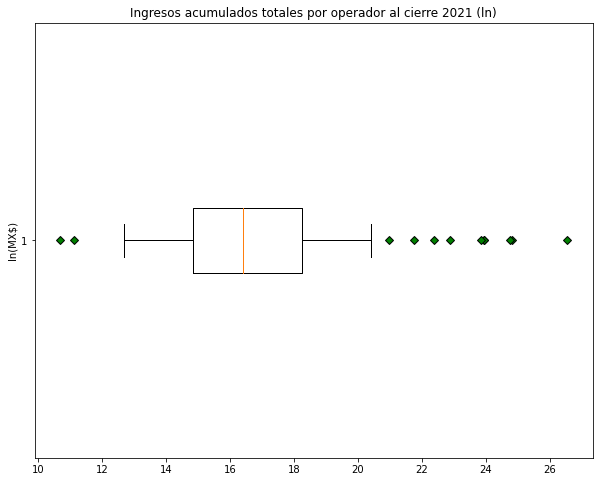

In [31]:
# Prueba de outliers (los grandes operadores)
green_diamond = dict(markerfacecolor='g', marker='D')
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.set_title('Ingresos acumulados totales por operador al cierre 2021 (ln)')
ax1.set_ylabel('ln(MX$)')
ax1.boxplot(ln_ingresos, flierprops=green_diamond, whis=0.75, vert=False)
plt.savefig('criterio_2021.png')
plt.show()

In [32]:
ln_ingresos

4     27
36    25
6     25
98    24
60    24
      ..
35    13
100   13
9     13
23    11
18    11
Name: INGRESOS_TOTAL_E, Length: 116, dtype: float64

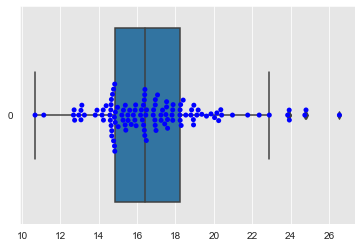

In [33]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
df = ln_ingresos

# Usual boxplot
ax = sns.boxplot(data=df, orient="h")
 
# Add jitter with the swarmplot function
ax = sns.swarmplot(color="blue", data=df, orient="h")
plt.show()

In [34]:
ln_ingresos2 = pd.DataFrame(ln_ingresos)
ln_ingresos3 = ln_ingresos2['INGRESOS_TOTAL_E'].values.astype("float")
ln_ingresos3


array([26.54725844, 24.80590037, 24.74492825, 23.93699178, 23.92912823,
       23.84932993, 22.89143199, 22.36395156, 21.76516941, 20.97079665,
       20.40738094, 20.36302965, 20.25101676, 20.15707471, 20.03705847,
       19.85197294, 19.61552768, 19.37098874, 19.18188829, 19.11320254,
       18.95721111, 18.94029603, 18.93160975, 18.839676  , 18.80296931,
       18.53793852, 18.40104514, 18.29509691, 18.26841012, 18.24271372,
       18.23952603, 18.23136339, 17.87444519, 17.85650317, 17.85650317,
       17.81938348, 17.58694855, 17.5840466 , 17.53620457, 17.53359844,
       17.49869154, 17.43859714, 17.32545666, 17.24938221, 17.23915779,
       17.06328059, 16.98351405, 16.94890035, 16.94587848, 16.94001508,
       16.92525951, 16.85900466, 16.83961608, 16.49178006, 16.47749274,
       16.45282239, 16.40532671, 16.39876071, 16.39437544, 16.37500708,
       16.374549  , 16.33565069, 16.32880917, 16.27224068, 16.22246178,
       16.1787748 , 15.94609271, 15.92101231, 15.89424763, 15.88

In [35]:
ln_ingresos2.index

Int64Index([  4,  36,   6,  98,  60, 102,   7,  62,   3,  84,
            ...
             91,  47,  50,  12,  45,  35, 100,   9,  23,  18],
           dtype='int64', length=116)

# Buscando el número de centroides (valores medios) óptimos a partir de la metodología Elbow y minimizar las distorciones.

In [36]:
ln_ingresos3.shape

(116,)

In [37]:
# Cuantificando las distorsiones.

from sklearn.cluster import KMeans
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(ln_ingresos3.reshape(-1, 1))
    distortions.append(kmeanModel.inertia_)

D:\Users\rodrigo.guarneros\Anaconda4\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


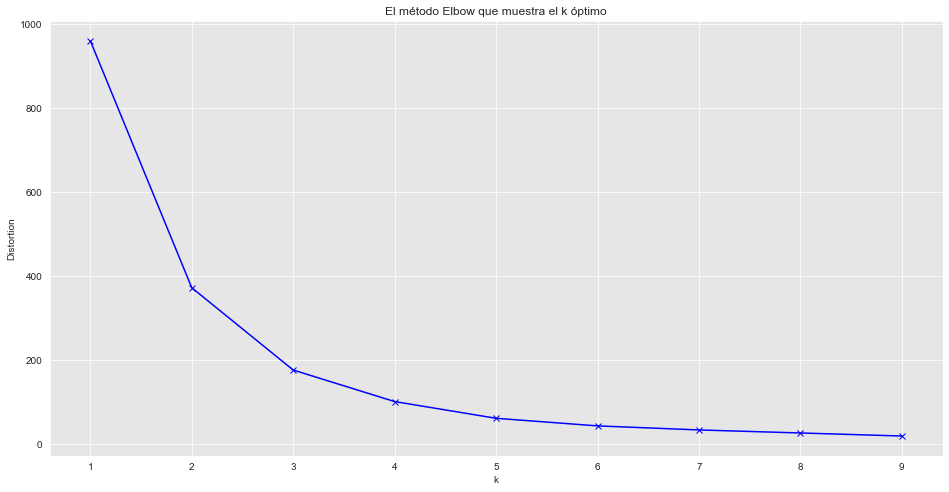

In [38]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('El método Elbow que muestra el k óptimo')
plt.show()

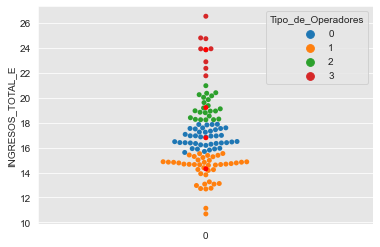

In [39]:
# Busquemos los clusters estadísticamente significativos
#use the kmeans function from scipy
from numpy import random
random.seed((1000,2000))
centroids, avg_distance = kmeans(ln_ingresos3, 4, iter=1000)
#extract the groups from the data
groups, cdit = vq(ln_ingresos3, centroids)
#plot the results
#assign groups back to the dataframe
ln_ingresos2["Tipo_de_Operadores"] = groups
#plot the scatter plot
# Usual boxplot

ax = sns.swarmplot(data=ln_ingresos2, x=np.ones(len(ln_ingresos2)), 
              y='INGRESOS_TOTAL_E', 
              hue=ln_ingresos2['Tipo_de_Operadores'])

ax = sns.swarmplot(data=centroids, color="red")
#ax = sns.boxplot(data=ln_ingresos2["INGRESOS_TOTAL_E"])

# remove legend if necessary
# plt.legend().remove()
plt.savefig('clusters_ingresos.png')
plt.show()

In [40]:
grande = ln_ingresos2[ln_ingresos2['Tipo_de_Operadores']==3].reset_index()
grande

mediano =  ln_ingresos2[ln_ingresos2['Tipo_de_Operadores']==2].reset_index()
mediano

pequeño1 = ln_ingresos2[ln_ingresos2['Tipo_de_Operadores']==0].reset_index()
pequeño1

pequeño2 = ln_ingresos2[ln_ingresos2['Tipo_de_Operadores']==1].reset_index()
pequeño2

,index,INGRESOS_TOTAL_E,Tipo_de_Operadores
0,0,16,1
1,92,16,1
2,40,15,1
3,27,15,1
4,63,15,1
5,94,15,1
6,31,15,1
7,81,15,1
8,49,15,1
9,109,15,1


In [41]:
# Se reemplazan las variables categóricas por la etiqueta correspondiente
ln_ingresos2["Tipo_de_Operadores"].replace({2: "Mediano", 3: "Grande", 1:"Pequeño2", 0:"Pequeño1"}, inplace=True)
ln_ingresos2 = ln_ingresos2.reset_index()
ln_ingresos2

,index,INGRESOS_TOTAL_E,Tipo_de_Operadores
0,4,27,Grande
1,36,25,Grande
2,6,25,Grande
3,98,24,Grande
4,60,24,Grande
...,...,...,...
111,35,13,Pequeño2
112,100,13,Pequeño2
113,9,13,Pequeño2
114,23,11,Pequeño2


In [42]:
ingresos_por_grupo = ingresos_agrupados.reset_index()
cluster_total = ingresos_por_grupo.merge(ln_ingresos2, how='left', on='index')
cluster_total.to_csv("Clusters_totales2.csv", encoding="Latin1")

In [43]:
grande = ln_ingresos2[ln_ingresos2['Tipo_de_Operadores']=="Grande"]
grande

mediano =  ln_ingresos2[ln_ingresos2['Tipo_de_Operadores']=="Mediano"]
mediano

pequeño_1 = ln_ingresos2[ln_ingresos2['Tipo_de_Operadores']=="Pequeño1"]
pequeño_1

pequeño_2 = ln_ingresos2[ln_ingresos2['Tipo_de_Operadores']=="Pequeño2"]
pequeño_2

,index,INGRESOS_TOTAL_E,Tipo_de_Operadores
73,0,16,Pequeño2
74,92,16,Pequeño2
75,40,15,Pequeño2
76,27,15,Pequeño2
77,63,15,Pequeño2
78,94,15,Pequeño2
79,31,15,Pequeño2
80,81,15,Pequeño2
81,49,15,Pequeño2
82,109,15,Pequeño2


In [44]:
ln_ingresos2

,index,INGRESOS_TOTAL_E,Tipo_de_Operadores
0,4,27,Grande
1,36,25,Grande
2,6,25,Grande
3,98,24,Grande
4,60,24,Grande
...,...,...,...
111,35,13,Pequeño2
112,100,13,Pequeño2
113,9,13,Pequeño2
114,23,11,Pequeño2


D:\Users\rodrigo.guarneros\Anaconda4\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 17.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
D:\Users\rodrigo.guarneros\Anaconda4\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 18.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


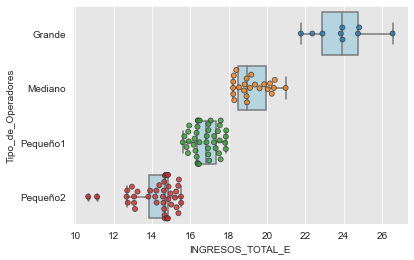

In [45]:
ax = sns.swarmplot(data=ln_ingresos2, x="INGRESOS_TOTAL_E", y="Tipo_de_Operadores", alpha=0.8, linewidth=.9)
ax = sns.boxplot(data=ln_ingresos2, x='INGRESOS_TOTAL_E', y="Tipo_de_Operadores",orient="h", color="lightblue")
plt.savefig("clusters_distribución.jpg")
#plt.show()

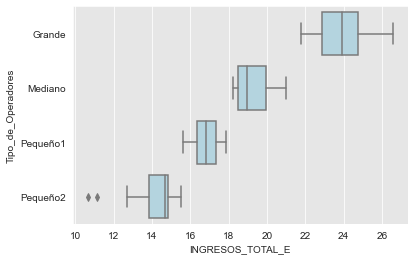

In [46]:
ax = sns.boxplot(data=ln_ingresos2, x='INGRESOS_TOTAL_E', y="Tipo_de_Operadores",orient="h", color="lightblue")

In [47]:
dir(ax)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_text',
 '_adjustable',
 '_agg_filter',
 '_alias_map',
 '_alpha',
 '_anchor',
 '_animated',
 '_aspect',
 '_autoscaleXon',
 '_autoscaleYon',
 '_autotitlepos',
 '_axes',
 '_axes_class',
 '_axes_locator',
 '_axisbelow',
 '_box_aspect',
 '_clipon',
 '_clippath',
 '_contains',
 '_convert_dx',
 '_current_image',
 '_default_contains',
 '_facecolor',
 '_fill_between_x_or_y',
 '_frameon',
 '_gci',
 '_gen_axes_patch',
 '_gen_axes_spines',
 '_get_axis_list',
 '_get_axis_map',
 '_get_clipping_extent_bbox',
 '_get_lines',
 '_get_patches_for_fill',
 '_get_view',
 '_gid',
 '_gridOn',
 '_in_layout',

In [48]:
print(ax.findobj())

[<matplotlib.lines.Line2D object at 0x000002230B019A60>, <matplotlib.lines.Line2D object at 0x000002230B019DC0>, <matplotlib.lines.Line2D object at 0x000002230B027160>, <matplotlib.lines.Line2D object at 0x000002230B0274C0>, <matplotlib.lines.Line2D object at 0x000002230B027820>, <matplotlib.lines.Line2D object at 0x000002230B027B80>, <matplotlib.lines.Line2D object at 0x000002230B033250>, <matplotlib.lines.Line2D object at 0x000002230B0335B0>, <matplotlib.lines.Line2D object at 0x000002230B033910>, <matplotlib.lines.Line2D object at 0x000002230B033CA0>, <matplotlib.lines.Line2D object at 0x000002230B03E040>, <matplotlib.lines.Line2D object at 0x000002230B03E3A0>, <matplotlib.lines.Line2D object at 0x000002230B03E940>, <matplotlib.lines.Line2D object at 0x000002230B03ECA0>, <matplotlib.lines.Line2D object at 0x000002230B04B070>, <matplotlib.lines.Line2D object at 0x000002230B04B3D0>, <matplotlib.lines.Line2D object at 0x000002230B04B730>, <matplotlib.lines.Line2D object at 0x000002230B

In [49]:
np.exp(17.7200000000003)

49624737.138494045

In [50]:
avg_distance

0.7200192223981352

# ¿Quiénes son los operadores en cada cluster?

In [51]:
# Primero preparemos la lista de operadores
ingresos = ingresos[['CONCESIONARIO', 'EMPRESA', 'GRUPO', 'INGRESOS_TOTAL_E']]
ingresos['INGRESOS_TOTAL_E'] = pd.to_numeric(ingresos['INGRESOS_TOTAL_E'])
ingresos = ingresos.groupby(['CONCESIONARIO', 'EMPRESA', 'GRUPO']).sum().reset_index().sort_values(by=['INGRESOS_TOTAL_E'], ascending=False)
ingresos

<ipython-input-51-daabab6c15c7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ingresos['INGRESOS_TOTAL_E'] = pd.to_numeric(ingresos['INGRESOS_TOTAL_E'])


,CONCESIONARIO,EMPRESA,GRUPO,INGRESOS_TOTAL_E
88,"RADIOMOVIL DIPSA, S.A. DE C.V.",TELCEL,AMÉRICA MÓVIL,218288998808
117,"TELEFONOS DE MEXICO, S.A.B. DE C.V.",TELMEX,AMÉRICA MÓVIL,120031140723
6,"AT&T COMUNICACIONES DIGITALES, S. DE R.L. DE C.V.",AT&T,AT&T,55793781168
87,"PEGASO PCS, S.A. DE C.V.",MOVISTAR,TELEFÓNICA,24871583943
33,CORPORACION DE RADIO Y TELEVISION DEL NORTE DE...,SKY,GRUPO TELEVISA,24112031768
...,...,...,...,...
45,"GRUPO CORPORATIVO ZUNUN PAZ, S. A. DE C.V.",GRUPO CORPORATIVO ZUNUN PAZ,GRUPO CORPORATIVO ZUNUN PAZ,340986
124,"TELMOV MOVIL, S.A. DE C.V.",TELMOVIL,TELMOVIL,332069
11,"BROCOMUNICACIONES MOVILES, S.A.P.I. DE C.V.",BROMOVIL,BROMOVIL,320585
36,EDUARDO PEDRERO PEREZ,EDUARDO PEDRERO PEREZ,EDUARDO PEDRERO PEREZ,68200


## Grandes

In [52]:
lista_grandes = grande["index"]
lista_original = ingresos_agrupados_transformables.reset_index()
grandes_operadores = lista_original[lista_original['index'].isin(lista_grandes)]
grandes_operadores.sort_values(by=["INGRESOS_TOTAL_E"], ascending=False)

,index,GRUPO,INGRESOS_TOTAL_E
0,4,AMÉRICA MÓVIL,338320139531
1,36,GRUPO TELEVISA,59301496226
2,6,AT&T,55793781168
3,98,TELEFÓNICA,24871583943
4,60,MEGACABLE-MCM,24676771857
5,102,TOTALPLAY,22784126736
6,7,AXTEL,8742237448
7,62,MVS,5158705766
8,3,ALTAN,2834607753


In [53]:
# Las empresas que no serían elegibles por estar en el cluster de los grandes operadores:

lista_cluster_grande = grandes_operadores['GRUPO'].unique()
lista_cluster_grande

array(['AMÉRICA MÓVIL', 'GRUPO TELEVISA', 'AT&T', 'TELEFÓNICA',
       'MEGACABLE-MCM', 'TOTALPLAY', 'AXTEL', 'MVS', 'ALTAN'],
      dtype=object)

In [54]:
# Se trata de 24 operadores que son por sí solos grandes operadores o pertenecen a un GIE grande. 

lista_empresas_cluster_grande = ingresos[ingresos['GRUPO'].isin(lista_cluster_grande)].sort_values(by=['INGRESOS_TOTAL_E'], ascending = False)

lista_empresas_cluster_grande.to_csv("Empresas_grandes.csv", encoding="Latin1")

lista_empresas_cluster_grande

,CONCESIONARIO,EMPRESA,GRUPO,INGRESOS_TOTAL_E
88,"RADIOMOVIL DIPSA, S.A. DE C.V.",TELCEL,AMÉRICA MÓVIL,218288998808
117,"TELEFONOS DE MEXICO, S.A.B. DE C.V.",TELMEX,AMÉRICA MÓVIL,120031140723
6,"AT&T COMUNICACIONES DIGITALES, S. DE R.L. DE C.V.",AT&T,AT&T,55793781168
87,"PEGASO PCS, S.A. DE C.V.",MOVISTAR,TELEFÓNICA,24871583943
33,CORPORACION DE RADIO Y TELEVISION DEL NORTE DE...,SKY,GRUPO TELEVISA,24112031768
76,"MEGA CABLE, S.A. DE C.V.",MEGACABLE,MEGACABLE-MCM,23567319612
125,"TOTAL PLAY TELECOMUNICACIONES, S.A. DE C.V.",TOTALPLAY,TOTALPLAY,22784126736
15,"CABLEMAS TELECOMUNICACIONES, S.A. DE C.V.",IZZI,GRUPO TELEVISA,9765026568
9,"AXTEL, S.A.B. DE C.V.",AXTEL,AXTEL,8742237448
20,"CABLEVISION, S.A. DE C.V.",CABLEVISION,GRUPO TELEVISA,7858397482


## Medianos

In [55]:
lista_medianos = mediano["index"]
lista_original = ingresos_agrupados_transformables.reset_index()
operadores_medianos = lista_original[lista_original['index'].isin(lista_medianos)]
operadores_medianos.sort_values(by=["INGRESOS_TOTAL_E"], ascending=False)

,index,GRUPO,INGRESOS_TOTAL_E
9,84,STARGROUP,1280858832
10,68,OUI,729143370
11,56,MARCATEL,697511564
12,103,TRANSTELCO,623598170
13,26,EUTELSAT AMERICAS,567683561
14,43,HNS DE MEXICO,503481972
15,42,HISPASAT,418410240
16,107,UC TELECOM,330305215
17,111,VERIZON SERVICIOS EMPRESARIALES MEXICO,258650617
18,10,BT LATAM MEXICO,214085985


In [56]:
# Las empresas que no serían elegibles por estar en el cluster de los medianos operadores:

lista_cluster_mediano = operadores_medianos['GRUPO'].unique()
lista_cluster_mediano

array(['STARGROUP', 'OUI', 'MARCATEL', 'TRANSTELCO', 'EUTELSAT AMERICAS',
       'HNS DE MEXICO', 'HISPASAT', 'UC TELECOM',
       'VERIZON SERVICIOS EMPRESARIALES MEXICO', 'BT LATAM MEXICO',
       'ELARA COMUNICACIONES', 'GLOBALSAT', 'NEWWW', 'WIMOTELECOM',
       'IENTC', 'VIRGIN MOBILE', 'FREEDOM', 'DIRI MOVIL', 'SIHI MEXICO',
       'FLASH MOBILE', 'IST', 'HIPERCABLE DE MONCLOVA', 'QUATTROCOM'],
      dtype=object)

In [57]:
# Se trata de 27 operadores que son por sí solos son medianos operadores o pertenecen a un GIE mediano. 

lista_empresas_cluster_medianos = ingresos[ingresos['GRUPO'].isin(lista_cluster_mediano)].sort_values(by=['INGRESOS_TOTAL_E'], ascending = False)

lista_empresas_cluster_medianos.to_csv("Empresas_medianas.csv", encoding="Latin1")

lista_empresas_cluster_medianos

,CONCESIONARIO,EMPRESA,GRUPO,INGRESOS_TOTAL_E
47,"GRUPO W COM, S.A. DE C.V.",STAR GO/STAR TV,STARGROUP,858427009
115,"TELECOMUNICACIONES 360, S.A. DE C.V.",OUI,OUI,729143370
71,"MARCATEL COM, S.A. DE C.V.",MARCATEL,MARCATEL,697511564
74,"MAXCOM TELECOMUNICACIONES, S.A.B. DE C.V.",MAXCOM,TRANSTELCO,623598170
93,"SATELITES MEXICANOS, S.A. DE C.V.",EUTELSAT AMERICAS,EUTELSAT AMERICAS,567683561
55,"HNS DE MEXICO, S.A. DE C.V.",HNS DE MEXICO,HNS DE MEXICO,503481972
122,"TELEVERA RED, S.A.P.I. DE C.V.",TELEVERA RED,STARGROUP,422431823
128,"UC TELECOMUNICACIONES, S.A.P.I. DE C.V.",UC TELECOM,UC TELECOM,330305215
132,"VERIZON SERVICIOS EMPRESARIALES MEXICO, S. DE ...",VERIZON SERVICIOS EMPRESARIALES MEXICO,VERIZON SERVICIOS EMPRESARIALES MEXICO,258650617
8,"AXESS NET.SOLUTIONS MEXICO, S.A. DE C.V.",AXESS,HISPASAT,217920735


## Cluster_1 de operadores pequeños

In [58]:
lista_pequeños1 = pequeño_1["index"]
operadores_pequeños_1 = lista_original[lista_original['index'].isin(lista_pequeños1)]
operadores_pequeños_1.sort_values(by=["INGRESOS_TOTAL_E"], ascending=False)

,index,GRUPO,INGRESOS_TOTAL_E
32,96,TELECABLE MERIDA,57912580
33,71,RAVS CABLE,56882777
34,99,TELESISTEMAS PENINSULARES,56882777
35,110,VASANTA,54810014
36,77,SIERRA MADRE TELECOM,43442490
37,115,YOBI TELECOM,43316605
38,20,COORDINADORA DE TV POR CABLE,41293042
39,72,RBACATV,41185567
40,53,LINK TE CONECTAMOS,39772709
41,88,TELECABLE DE CAMPECHE,37452991


In [59]:
# Las empresas que no serían elegibles por estar en el cluster de los pequeños1:
lista_cluster_pequeños_1 = operadores_pequeños_1['GRUPO'].unique()
lista_cluster_pequeños_1

array(['TELECABLE MERIDA', 'RAVS CABLE', 'TELESISTEMAS PENINSULARES',
       'VASANTA', 'SIERRA MADRE TELECOM', 'YOBI TELECOM',
       'COORDINADORA DE TV POR CABLE', 'RBACATV', 'LINK TE CONECTAMOS',
       'TELECABLE DE CAMPECHE', 'WEEX', 'BBG COMUNICACION',
       'SARA QUIROZ CHAPA', 'CCA', 'GILAT', 'CABLEVISION DE APATZINGAN',
       'MARCO ANTONIO ROSALES HERRERA', 'TOKA MOVIL', 'NEXT TELEKOM',
       'TELECABLE DE XALTIANGUIS', 'TELECOM NACIONAL', 'USA TELECOM',
       'SUPERCOM', 'TELECABLE DE TICUL', 'AIRECABLE',
       'OPERADORA TELEFONICA PENINSULAR', 'MAXICABLE', 'COMCAB',
       'GURUCOMM', 'CABLEPLAY', 'SIMPATI', 'MUCHOS MEGAS', 'LOGITEL',
       'OTROS', 'TV OJO CALIENTE', 'FRANCISCO GUERRA GARCIA',
       'TELECABLE DE COAHUAYANA', 'TELECABLE DE CUERNAVACA', 'BUENO CELL',
       'SISTV', 'TVDIG'], dtype=object)

In [60]:
# Se trata de 42 operadores que por sí solos son pequeños operadores o pertenecen a un GIE pequeño. 

lista_empresas_cluster_pequeños_1 = ingresos[ingresos['GRUPO'].isin(lista_cluster_pequeños_1)].sort_values(by=['INGRESOS_TOTAL_E'], ascending = False)

lista_empresas_cluster_pequeños_1.to_csv("Empresas_pequeñas_c1.csv", encoding="Latin1")

lista_empresas_cluster_pequeños_1

,CONCESIONARIO,EMPRESA,GRUPO,INGRESOS_TOTAL_E
109,"TELECABLE DE MERIDA, S.A. DE C.V.",TELECABLE MERIDA,TELECABLE MERIDA,57912580
119,"TELESISTEMAS PENINSULARES, S.A. DE C.V.",TELESISTEMAS PENINSULARES,TELESISTEMAS PENINSULARES,56882777
90,ROBERTO ANTONIO MALDONADO GUTIERREZ,RAVS CABLE,RAVS CABLE,56882777
131,"VASANTA COMUNICACIONES, S.A.P.I. DE C.V.",VASANTA,VASANTA,54810014
94,"SIERRA MADRE INTERNET, S.A. DE C.V.",SIERRA MADRE,SIERRA MADRE TELECOM,43442490
21,"CELMAX MOVIL, S.A. DE C.V.",YOBI TELECOM,YOBI TELECOM,43316605
32,"COORDINADORA DE TV POR CABLE, S.A. DE C.V.",COORDINADORA DE TV POR CABLE,COORDINADORA DE TV POR CABLE,41293042
89,"RBA CATV, S.A. DE C.V.",RBACATV,RBACATV,41185567
105,"TELECABLE DE CAMPECHE, S.A. DE C.V.",TELECABLE DE CAMPECHE,TELECABLE DE CAMPECHE,37452991
27,"COMRELOADED, S.A.P.I. DE C.V.",WEEX,WEEX,33446465


# Cluster 2 de operadores pequeños

In [61]:
lista_pequeños2 = pequeño_2["index"]
operadores_pequeños_2 = lista_original[lista_original['index'].isin(lista_pequeños2)]
operadores_pequeños_2.sort_values(by=["INGRESOS_TOTAL_E"], ascending=False)

,index,GRUPO,INGRESOS_TOTAL_E
73,0,ADDINTELI,5534961
74,92,TELECABLE DE TEKAX,5473549
75,40,HERMOVISION,4917794
76,27,EYCO DE LOS ALTOS,4796983
77,63,NET LINK,4756865
78,94,TELECABLE DE VILLANUEVA,4355978
79,31,GABRIEL BUTRON CHIAPA,4266116
80,81,SISCAB DE MEXICO,4003498
81,49,JACE TELECOM,3300058
82,109,VADSA,3185056


In [62]:
# Las empresas que no serían elegibles por estar en el cluster de los pequeños1:
lista_cluster_pequeños_2 = operadores_pequeños_2['GRUPO'].unique()
lista_cluster_pequeños_2

array(['ADDINTELI', 'TELECABLE DE TEKAX', 'HERMOVISION',
       'EYCO DE LOS ALTOS', 'NET LINK', 'TELECABLE DE VILLANUEVA',
       'GABRIEL BUTRON CHIAPA', 'SISCAB DE MEXICO', 'JACE TELECOM',
       'VADSA', 'STAR NET', 'SINOTECA', 'GUILLERMO MEDELLIN MILAN',
       'ARELY ISABEL GONGORA PECH', 'AGUSTIN PEREZ VIEYRA', 'SECSA',
       'INTEGRA COMUNICACIONES', 'GOBO', 'TELECABLE DE AGUILILLA',
       'TELECAB', 'ROBERTO LOPEZ BRAVO', 'MARKETING 358', 'CONCABLETV',
       'JESUS MIGUEL FERNANDEZ GUERRERO', 'ESPID', 'MANUEL LOPEZ AVILA',
       'RED DOG', 'GUILLERMO ZARATE GARCIA',
       'JOSE JULIAN SACRAMENTO GARZA', 'CABLEVISION DE LA HUACANA',
       'CRO.NET', 'TV-K', 'QBO CEL', 'TELECABLE DE MARIANO ESCOBEDO',
       'ISALIA MORENO ZETINA', 'JAIME SANCHEZ SANCHEZ',
       'CABLE SISTEMA DEL CENTRO', 'IGOU TELECOM',
       'GRUPO CORPORATIVO ZUNUN PAZ', 'TELMOVIL', 'BROMOVIL',
       'EDUARDO PEDRERO PEREZ', 'COMNET'], dtype=object)

In [63]:
# Se trata de 43 operadores que por sí solos son pequeños operadores o pertenecen a un GIE pequeño. 

lista_empresas_cluster_pequeños_2 = ingresos[ingresos['GRUPO'].isin(lista_cluster_pequeños_2)].sort_values(by=['INGRESOS_TOTAL_E'], ascending = False)

lista_empresas_cluster_pequeños_2.to_csv("Empresas_pequeñas_c2.csv", encoding="Latin1")

lista_empresas_cluster_pequeños_2

,CONCESIONARIO,EMPRESA,GRUPO,INGRESOS_TOTAL_E
1,AGREGADORA DE INTELIGENCIA EN NEGOCIOS TECNOLO...,ADDINTELI,ADDINTELI,5534961
110,"TELECABLE DE TEKAX, S.A. DE C.V.",TELECABLE DE TEKAX,TELECABLE DE TEKAX,5473549
52,"HERMOVISION, S. DE R.L. DE C.V.",HERMOVISION,HERMOVISION,4917794
39,"EYCO DE LOS ALTOS, S. DE R.L. DE C.V.",EYCO DE LOS ALTOS,EYCO DE LOS ALTOS,4796983
80,NATALIA CHAREEVA,NET LINK,NET LINK,4756865
112,"TELECABLE DE VILLANUEVA, S.A. DE C.V.",TELECABLE DE VILLANUEVA,TELECABLE DE VILLANUEVA,4355978
42,GABRIEL BUTRON CHIAPA,GABRIEL BUTRON CHIAPA,GABRIEL BUTRON CHIAPA,4266116
97,"SISCAB DE MEXICO, S.A. DE C.V.",SISCAB DE MEXICO,SISCAB DE MEXICO,4003498
61,"JACE TELECOM, S.A. DE C.V.",JACE TELECOM,JACE TELECOM,3300058
130,"VALOR AGREGADO DIGITAL, S.A. DE C.V.",VADSA,VADSA,3185056


In [94]:
total_ingresos = ingresos_agrupados_transformables["INGRESOS_TOTAL_E"].sum()
ingreos_grandes= lista_empresas_cluster_grande["INGRESOS_TOTAL_E"].sum()
ingresos_medianas = lista_empresas_cluster_medianos["INGRESOS_TOTAL_E"].sum()
ingresos_pequeñas1 = lista_empresas_cluster_pequeños_1["INGRESOS_TOTAL_E"].sum()
ingresos_pequeñas2 = lista_empresas_cluster_pequeños_2["INGRESOS_TOTAL_E"].sum()

print(f"El 17.6% del total de empresas(cluster empresas grandes) generan el {round(ingreos_grandes/total_ingresos*100,2)}% de los ingresos")
print(f"El 19.9% del total de empresas (cluster empresas medianas) generan el {round(ingresos_medianas/total_ingresos*100,2)}% de los ingresos")
print(f"El 62.5% del total de empresas (cluster empresas pequeñas 1 y 2) generan el {round((ingresos_pequeñas1+ingresos_pequeñas2)/total_ingresos*100,2)}% de los ingresos")



El 17.6% del total de empresas(cluster empresas grandes) generan el 98.49% de los ingresos
El 19.9% del total de empresas (cluster empresas medianas) generan el 1.32% de los ingresos
El 62.5% del total de empresas (cluster empresas pequeñas 1 y 2) generan el 0.19% de los ingresos


In [95]:
# Análisis con quartiles y rango intercuantil para efectos de identificar los outliers

quartiles = lista_empresas_cluster_pequeños_1["INGRESOS_TOTAL_E"].quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"El cuartil más bajo de los ingresos es: {lowerq}")
print(f"El cuartil más alto de los ingresos es: {upperq}")
print(f"El rango intercuantil de los ingresos es: {iqr}")
print(f"El ingreso medio es: {quartiles[0.5]} ")


lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr) # se circunscribe al 95.44% de los datos.
print(f"Umbral final donde los valores por encima de {upper_bound} no son elegibles.")



El cuartil más bajo de los ingresos es: 12366774.265
El cuartil más alto de los ingresos es: 30917591.53
El rango intercuantil de los ingresos es: 18550817.265
El ingreso medio es: 18037350.475 
Umbral final donde los valores por encima de 58743817.4275 no son elegibles.


# Conclusiones

### <font color="green"> El umbral para ser elegible como pequeño operador implica ingresos nominales acumulados al cierre de 2021 menores o iguales a <font color="red"> MX$58,743,817 </font>, para efectos de garantizar que la empresa en cuestión se encuentra dentro de alguno de los dos clusters identificados por su ingreso relativamente pequeño.

- Con base en los datos del BIT se registran 85 empresas con ingresos menores o iguales al umbral definido. Esto equivale al 62.5% de todas las empresas.

- El 17.6% del total de empresas (cluster empresas grandes) generan el 98.49% de los ingresos.

- El 19.9% del total de empresas (cluster empresas medianas) generan el 1.32% de los ingresos.

- El 62.5% del total de empresas (cluster empresas pequeñas 1 y 2) generan el 0.19% de los ingresos.

- La definición de este umbral con base en una técnica confiable y robusta permite contar con un criterio cuantitativo y objetivo sobre lo que se debe considerar como un operador elegible para participar en el Comité de Pequeños Operadores.

-  Se trata de un criterio claro, transparente y replicable, que brinda certeza jurídica y confianza al sector.

</font>

